web version: [link]

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt

import requests
import json

In [2]:
#crawl historical trading data from trading view of SSI Iboard API
def data_from_tradingview(symbol):
    #API's URL
    trading_view_data_url = 'https://iboard.ssi.com.vn/dchart/api/history'
    #response template
    data_json = {
        'date': [],
        'open': [],
        'high': [],
        'low': [],
        'close': [],
        'volume': [],
    }

    now = dt.datetime.now()
    current_year = now.year
    
    for year in range(2000, current_year+1):
        #config duration of data
        begin_date = int(dt.datetime(year, 1, 1).timestamp())
        end_date = int(dt.datetime(year, 12, 31).timestamp())
        #call API
        response = requests.get(
            f'{trading_view_data_url}?symbol={symbol}&resolution=D&from={begin_date}&to={end_date}')

        response_data = json.loads(response.text)
        data_json['date'].extend(response_data['t'])
        data_json['open'].extend(response_data['o'])
        data_json['high'].extend(response_data['h'])
        data_json['low'].extend(response_data['l'])
        data_json['close'].extend(response_data['c'])
        data_json['volume'].extend(response_data['v'])

    #format response data
    df = pd.DataFrame(data_json)
    df=df.mask(df == '')
    df = df.astype(float)

    df['date'] = pd.to_datetime(df['date'], unit='s')
    df = df.set_index('date').sort_index()
    df = df.loc[~df.index.duplicated(keep='first')]
    return df


In [3]:
#config symbol(s) that be visualized
symbol_list = ['VND','SSI']

historical_data_list = []
for symbol in symbol_list:
    stock_historical_data = data_from_tradingview(symbol)
    historical_data_list.append(stock_historical_data)

historical_data_frame = pd.concat(historical_data_list, axis=1, keys=symbol_list)
historical_data_frame.columns.names = ['Symbol','Stock_Info']

historical_data_frame

Symbol        VND                                     SSI                \
Stock_Info   open   high    low  close      volume   open   high    low   
date                                                                      
2006-12-15    NaN    NaN    NaN    NaN         NaN   7.66  21.90   0.01   
2006-12-18    NaN    NaN    NaN    NaN         NaN   9.31   9.98   9.31   
2006-12-19    NaN    NaN    NaN    NaN         NaN  10.68  10.81   9.91   
2006-12-20    NaN    NaN    NaN    NaN         NaN  11.84  11.84  10.73   
2006-12-21    NaN    NaN    NaN    NaN         NaN  10.95  10.95  10.28   
...           ...    ...    ...    ...         ...    ...    ...    ...   
2022-12-20  15.45  15.70  14.60  15.20  40213600.0  20.50  20.75  19.35   
2022-12-21  15.50  15.55  14.15  14.65  37810900.0  20.20  20.20  18.45   
2022-12-22  14.90  15.00  14.10  14.55  26054800.0  19.50  19.55  18.60   
2022-12-23  14.50  14.50  13.90  14.00  20229500.0  19.00  19.10  18.25   
2022-12-26  13.85  14.00  13.05  13.05  28499900.0  18.20  18.30  17.05   

Symbol                         
Stock_Info  close      volume  
date                           
2006-12-15   9.98    293000.0  
2006-12-18   9.31    340200.0  
2006-12-19  10.68    326900.0  
2006-12-20  10.73    651600.0  
2006-12-21  10.28    200100.0  
...           ...         ...  
2022-12-20  19.80  26808800.0  
2022-12-21  19.30  26446400.0  
2022-12-22  19.10  13108700.0  
2022-12-23  18.30  11363200.0  
2022-12-26  17.05  18630300.0  

[3966 rows x 10 columns]

In [4]:
import plotly.graph_objects as go
import ta
from plotly.subplots import make_subplots
import plotly.express as px

In [38]:
for stock in symbol_list:
    fig = make_subplots(rows=2, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.03,
                        row_width=[0.2, 0.7]
                        )

    specific_data = pd.DataFrame(historical_data_frame[stock])
    specific_data = specific_data.dropna()

    specific_data["MA20"] = ta.trend.sma_indicator(specific_data['close'], window=20)
    specific_data["MA50"] = ta.trend.sma_indicator(specific_data['close'], window=50)
    specific_data["MA100"] = ta.trend.sma_indicator(specific_data['close'], window=100)

    fig.add_trace(go.Scatter(x=specific_data.index, y=specific_data['MA20'], name="MA20",line=dict(color = 'orange',width=0.5)))
    fig.add_trace(go.Scatter(x=specific_data.index, y=specific_data['MA50'], name="MA50",line=dict(color = 'black',width=0.5)))
    fig.add_trace(go.Scatter(x=specific_data.index, y=specific_data['MA100'], name="MA100",line=dict(color = 'blue',width=0.5)))

    fig.add_trace(go.Candlestick(x=specific_data.index,
                                 open=specific_data['open'],
                                 high=specific_data['high'],
                                 low=specific_data['low'],
                                 close=specific_data['close'], name=stock),
                  row=1, col=1)
    # Bar trace for volumes on 2nd row without legend
    fig.add_trace(go.Bar(
        x=specific_data.index, y=specific_data['volume'], showlegend=False,marker=dict(color='blue'),opacity=1), row=2, col=1)

    # Do not show rangeslider plot
    fig.update(layout_xaxis_rangeslider_visible=False)

    fig.update_layout(
        autosize=False,
        width=780,
        height=540,
        title_text=stock+'\'S HISTORICAL TRADING DATA CHART'
    )

    fig.show()

## **COMPARE WITH VNINDEX**

In [6]:
#compare with VNINDEX
vn_index_symbol = 'VNINDEX'
vn_index_historical_data = data_from_tradingview(vn_index_symbol)


compare_symbol_list = []
compare_symbol_list.extend(symbol_list)
compare_symbol_list.append(vn_index_symbol)


compare_data_list = []
compare_data_list.extend(historical_data_list)
compare_data_list.append(vn_index_historical_data)

compare_data_frame = pd.concat(compare_data_list, axis=1, keys=compare_symbol_list)
compare_data_frame = compare_data_frame.dropna()
compare_data_frame.columns.names = ['Symbol','Historical_Data']
compare_data_frame


Symbol             VND                                     SSI                \
Historical_Data   open   high    low  close      volume   open   high    low   
date                                                                           
2010-03-30        2.94   3.06   2.77   2.87    869800.0  11.32  11.40  11.04   
2010-03-31        2.90   3.01   2.87   2.97    542900.0  10.97  11.17  10.97   
2010-04-01        2.98   3.06   2.97   3.01    372900.0  10.92  11.17  10.84   
2010-04-02        3.03   3.03   2.87   2.99    569400.0  11.15  11.30  11.04   
2010-04-05        2.94   3.08   2.87   3.08    748500.0  11.25  11.35  11.20   
...                ...    ...    ...    ...         ...    ...    ...    ...   
2022-12-20       15.45  15.70  14.60  15.20  40213600.0  20.50  20.75  19.35   
2022-12-21       15.50  15.55  14.15  14.65  37810900.0  20.20  20.20  18.45   
2022-12-22       14.90  15.00  14.10  14.55  26054800.0  19.50  19.55  18.60   
2022-12-23       14.50  14.50  13.90  14.00  20229500.0  19.00  19.10  18.25   
2022-12-26       13.85  14.00  13.05  13.05  28499900.0  18.20  18.30  17.05   

Symbol                              VNINDEX                             \
Historical_Data  close      volume     open     high      low    close   
date                                                                     
2010-03-30       11.04   1728000.0   504.71   506.29   500.72   500.72   
2010-03-31       10.97   1577570.0   501.85   504.00   499.24   499.24   
2010-04-01       11.10   1745340.0   500.37   508.91   499.99   508.18   
2010-04-02       11.15   1563440.0   510.38   512.99   508.54   510.48   
2010-04-05       11.22   1016450.0   514.17   516.27   513.45   514.79   
...                ...         ...      ...      ...      ...      ...   
2022-12-20       19.80  26808800.0  1035.82  1038.74  1010.08  1023.13   
2022-12-21       19.30  26446400.0  1033.34  1033.84  1005.43  1018.88   
2022-12-22       19.10  13108700.0  1026.49  1033.18  1016.54  1022.61   
2022-12-23       18.30  11363200.0  1023.69  1027.34  1013.20  1020.34   
2022-12-26       17.05  18630300.0  1019.66  1021.89   985.21   985.21   

Symbol                        
Historical_Data       volume  
date                          
2010-03-30        47215800.0  
2010-03-31        45342680.0  
2010-04-01        41808032.0  
2010-04-02        39486488.0  
2010-04-05        42519132.0  
...                      ...  
2022-12-20       954038800.0  
2022-12-21       703570400.0  
2022-12-22       531712600.0  
2022-12-23       423823400.0  
2022-12-26       566850100.0  

[3159 rows x 15 columns]

In [7]:
compare_percent_change = pd.DataFrame()
for name in compare_symbol_list:
    compare_percent_change[name] = compare_data_frame[name]['close'].apply(lambda x: (x/(compare_data_frame[name]['close'][0])-1)*100)
compare_percent_change

,VND,SSI,VNINDEX
date,,,
2010-03-30,0.000000,0.000000,0.000000
2010-03-31,3.484321,-0.634058,-0.295574
2010-04-01,4.878049,0.543478,1.489855
2010-04-02,4.181185,0.996377,1.949193
2010-04-05,7.317073,1.630435,2.809954
...,...,...,...
2022-12-20,429.616725,79.347826,104.331762
2022-12-21,410.452962,74.818841,103.482985
2022-12-22,406.968641,73.007246,104.227912


In [29]:
compare_fig = make_subplots(rows=1, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.03)

for stock in compare_symbol_list:
    compare_fig.add_trace(go.Scatter(
        x=compare_percent_change[stock].index, y=compare_percent_change[stock], name=stock,line=dict(width=1)))
    
# Do not show rangeslider plot
compare_fig.update(layout_xaxis_rangeslider_visible=False)

compare_fig.update_layout(
    autosize=False,
    width=780,
    height=540,
    title_text="Percentage Change From " + str(compare_percent_change.index[0].date())
)

compare_fig

In [12]:
#compare percentage change by day
percent_change_by_day = pd.DataFrame()
for name in compare_symbol_list:
    percent_change_by_day[name] = compare_data_frame[name]['close'].pct_change()
percent_change_by_day

,VND,SSI,VNINDEX
date,,,
2010-03-30,NaN,NaN,NaN
2010-03-31,0.034843,-0.006341,-0.002956
2010-04-01,0.013468,0.011851,0.017907
2010-04-02,-0.006645,0.004505,0.004526
2010-04-05,0.030100,0.006278,0.008443
...,...,...,...
2022-12-20,-0.019355,-0.034146,-0.014705
2022-12-21,-0.036184,-0.025253,-0.004154
2022-12-22,-0.006826,-0.010363,0.003661


In [17]:
percent_change_by_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3159 entries, 2010-03-30 to 2022-12-26
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   VND      3158 non-null   float64
 1   SSI      3158 non-null   float64
 2   VNINDEX  3158 non-null   float64
dtypes: float64(3)
memory usage: 227.8 KB


In [18]:
percent_change_by_day.dropna()

,VND,SSI,VNINDEX
date,,,
2010-03-31,0.034843,-0.006341,-0.002956
2010-04-01,0.013468,0.011851,0.017907
2010-04-02,-0.006645,0.004505,0.004526
2010-04-05,0.030100,0.006278,0.008443
2010-04-06,-0.022727,-0.013369,0.001049
...,...,...,...
2022-12-20,-0.019355,-0.034146,-0.014705
2022-12-21,-0.036184,-0.025253,-0.004154
2022-12-22,-0.006826,-0.010363,0.003661


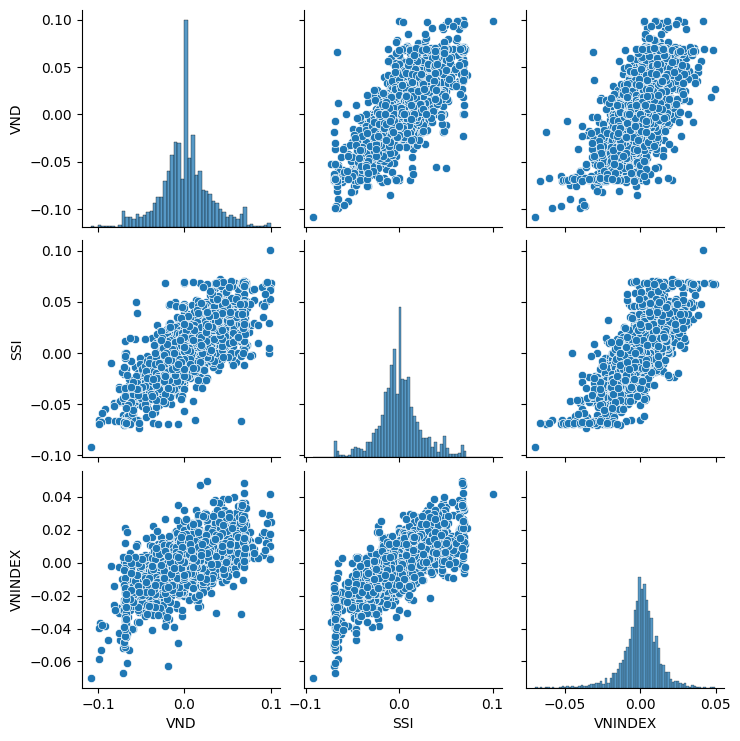

In [19]:
import seaborn as sns
sns.pairplot(percent_change_by_day)

<Figure size 1500x500 with 0 Axes>

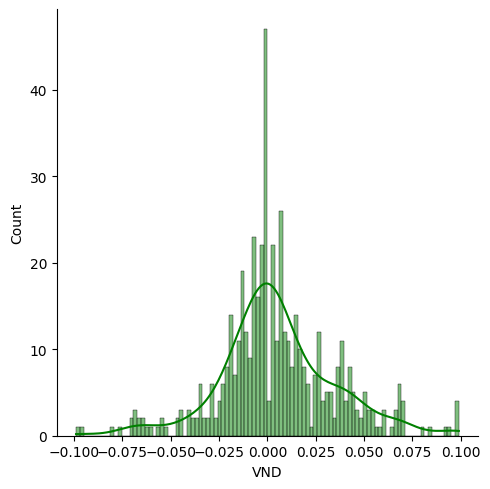

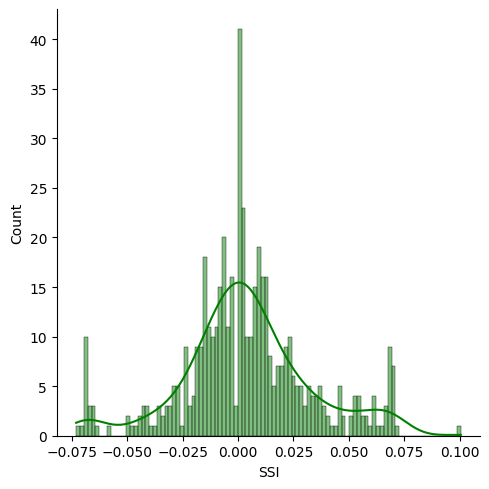

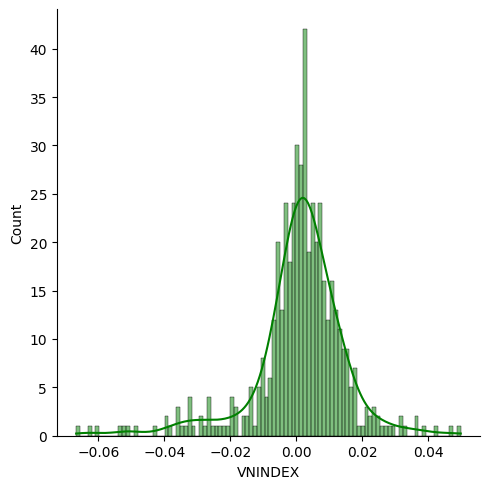

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

# thể hiện percentage change của giá chứng khoán bằng phân phối chuẩn(sửa tiếng anh dùm nha)
for stock in percent_change_by_day.columns:
    sns.displot(percent_change_by_day.loc['2020-01-01':'2021-12-31'][stock],color='green',bins=100, kde=True)

<AxesSubplot: >

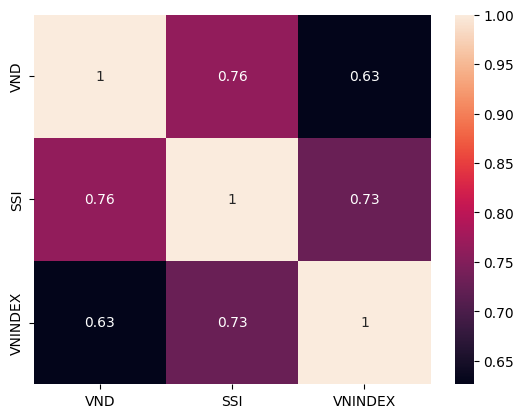

In [21]:
sns.heatmap(percent_change_by_day.corr(), annot=True)